In [12]:
#This notebook takes a previously trained RNN and evaluates it on held-out data, saving the outputs for later processing.
#We also compute here the overall character error rate and word error rate across all held-out data. 
#本笔记本采用之前训练过的RNN，并根据保留的数据对其进行评估，保存输出以供以后处理。
#我们还计算了所有保留数据的整体字符错误率和单词错误率。

In [13]:
import tensorflow as tf

#suppress all tensorflow warnings (largely related to compatability with v2)
#抑制所有tensorflow警告（主要与v2的兼容性有关）
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
from datetime import datetime
from charSeqRNN import charSeqRNN, getDefaultRNNArgs

#point this towards the top level dataset directory
#将其指向顶级数据集目录
rootDir = os.path.expanduser('~') + '/handwritingBCIData/'

#evaluate the RNN on these datasets
#在这些数据集上评估RNN
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']

#use this train/test partition
#使用此训练/测试分区
cvPart = 'HeldOutTrials'

#point this towards the specific RNN we want to evaluate
#将其指向我们要评估的特定RNN
rnnOutputDir = cvPart

#this prevents tensorflow from taking over more than one gpu on a multi-gpu machine
#这可以防止tensorflow在多gpu机器上接管多个gpu
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'

#this is where we're going to save the RNN outputs
#这就是我们要保存RNN输出的地方
inferenceSaveDir = rootDir+'RNNTrainingSteps/Step5_RNNInference/' + rnnOutputDir

if not os.path.isdir(rootDir + 'RNNTrainingSteps/Step5_RNNInference'):
    os.mkdir(rootDir + 'RNNTrainingSteps/Step5_RNNInference')
    
if not os.path.isdir(inferenceSaveDir):
    os.mkdir(inferenceSaveDir)

In [14]:
#Configures the RNN for inference mode.
#将RNN配置为推理模式。
args = getDefaultRNNArgs()

args['outputDir'] = rootDir+'RNNTrainingSteps/Step4_RNNTraining/'+rnnOutputDir
args['loadDir'] = args['outputDir']
args['mode'] = 'infer'
args['timeSteps'] = 7500 #Need to specify enough time steps so that the longest sentence fits in the minibatch
                         #需要指定足够的时间步长，以便最长的句子适合小批量
args['batchSize'] = 2 #Process just two sentences at a time, to make sure we have enough memory
                      #一次只处理两个句子，以确保我们有足够的记忆力
args['synthBatchSize'] = 0 #turn off synthetic data here, we are only using real data
                        #在这里关闭合成数据，我们只使用真实数据
#Proceeds one dataset at a time. Currently the code is setup to only process a single dataset at inference time,
#so we have to rebuild the graph for each dataset.
#一次处理一个数据集。目前，代码设置为在推断时仅处理单个数据集，
#因此，我们必须为每个数据集重建图形。
for x in range(len(dataDirs)):
    #configure the RNN to process this particular dataset
    #配置RNN以处理此特定数据集
    print(' ')
    print('Processing dataset ' + dataDirs[x])
    
    args['sentencesFile_0'] = rootDir+'Datasets/'+dataDirs[x]+'/sentences.mat'
    args['singleLettersFile_0'] = rootDir+'Datasets/'+dataDirs[x]+'/singleLetters.mat'
    args['labelsFile_0'] = rootDir+'RNNTrainingSteps/Step2_HMMLabels/'+cvPart+'/'+dataDirs[x]+'_timeSeriesLabels.mat'
    args['syntheticDatasetDir_0'] = rootDir+'RNNTrainingSteps/Step3_SyntheticSentences/'+cvPart+'/'+dataDirs[x]+'_syntheticSentences/'
    args['cvPartitionFile_0'] = rootDir+'RNNTrainingSteps/trainTestPartitions_'+cvPart+'.mat'
    args['sessionName_0'] = dataDirs[x]

    args['inferenceOutputFileName'] = inferenceSaveDir + '/' + dataDirs[x] + '_inferenceOutputs.mat'
    args['inferenceInputLayer'] = x
    
    #instantiate the RNN model
    #实例化RNN模型
    rnnModel = charSeqRNN(args=args)

    #evaluate the RNN on the held-out data
    #根据保留的数据评估RNN
    outputs = rnnModel.inference()
    
    #reset the graph to make space for the next dataset
    #重置图形以为下一个数据集腾出空间
    tf.reset_default_graph()


 
Processing dataset t5.2019.05.08
Loading from checkpoint: /home/fwillett/handwritingDatasetsForRelease/ProcessedData/Step4_RNNTraining/HeldOutTrials/model.ckpt-100000
Starting inference.
Done with inference.
 
Processing dataset t5.2019.11.25
Loading from checkpoint: /home/fwillett/handwritingDatasetsForRelease/ProcessedData/Step4_RNNTraining/HeldOutTrials/model.ckpt-100000
Starting inference.
Done with inference.
 
Processing dataset t5.2019.12.09
Loading from checkpoint: /home/fwillett/handwritingDatasetsForRelease/ProcessedData/Step4_RNNTraining/HeldOutTrials/model.ckpt-100000
Starting inference.
Done with inference.
 
Processing dataset t5.2019.12.11
Loading from checkpoint: /home/fwillett/handwritingDatasetsForRelease/ProcessedData/Step4_RNNTraining/HeldOutTrials/model.ckpt-100000
Starting inference.
Done with inference.
 
Processing dataset t5.2019.12.18
Loading from checkpoint: /home/fwillett/handwritingDatasetsForRelease/ProcessedData/Step4_RNNTraining/HeldOutTrials/model.ckp

In [ ]:
#This cell loads the outputs produced above and computes character error counts and word error counts.
#此单元格加载上面生成的输出，并计算字符错误计数和单词错误计数。
from characterDefinitions import getHandwritingCharacterDefinitions
from rnnEval import evaluateRNNOutput, rnnOutputToKaldiMatrices
import warnings

#this stops scipy.io.savemat from throwing a warning about empty entries
#这阻止了scipy.io.savemat 避免抛出关于空条目的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

charDef = getHandwritingCharacterDefinitions()
allErrCounts = []

for x in range(len(dataDirs)):
    print('-- ' + dataDirs[x] + ' --')
    
    #Load up the outputs, which are frame-by-frame probabilities. 
    #加载输出，即逐帧概率。
    outputs = scipy.io.loadmat(inferenceSaveDir + '/' + dataDirs[x] + '_inferenceOutputs.mat')
    sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/sentences.mat')
    
    #Convert the outputs into character sequences (with simple thresholding) & get word/character error counts.
    #将输出转换为字符序列（使用简单的阈值）并获取字/字符错误计数。
    errCounts, decSentences = evaluateRNNOutput(outputs['outputs'], 
                                        sentenceDat['numTimeBinsPerSentence']/2 + 50, 
                                        sentenceDat['sentencePrompt'], 
                                        charDef, 
                                        charStartThresh=0.3, 
                                        charStartDelay=15)
    
    #save decoded sentences, character error rates and word error rates for later summarization
    #保存已解码的句子、字符错误率和单词错误率，以便以后进行总结
    saveDict = {}
    saveDict['decSentences'] = decSentences
    saveDict['trueSentences'] = sentenceDat['sentencePrompt']
    saveDict.update(errCounts)
    
    scipy.io.savemat(inferenceSaveDir + '/' + dataDirs[x] + '_errCounts.mat', saveDict)
    
    #print results for the validation sentences
    #打印验证语句的结果
    cvPartFile = scipy.io.loadmat(rootDir+'RNNTrainingSteps/trainTestPartitions_'+cvPart+'.mat')
    valIdx = cvPartFile[dataDirs[x]+'_test']
    
    if len(valIdx)==0:
        print('No validation sentences for this session.')
        print('  ')
        continue
            
    valAcc = 100*(1 - np.sum(errCounts['charErrors'][valIdx]) / np.sum(errCounts['charCounts'][valIdx]))

    print('Character error rate for this session: %1.2f%%' % float(100-valAcc))
    print('Below is the decoder output for all validation sentences in this session:')
    print(' ')
    
    for v in np.squeeze(valIdx):
        trueText = sentenceDat['sentencePrompt'][v,0][0]
        trueText = trueText.replace('>',' ')
        trueText = trueText.replace('~','.')
        trueText = trueText.replace('#','')
        
        print('#' + str(v) + ':')
        print('True:    ' + trueText)
        print('Decoded: ' + decSentences[v])
        print(' ')
   
    #put together all the error counts from all sessions so we can compute overall error rates below
    #将所有会话的所有错误计数放在一起，这样我们就可以计算下面的总体错误率
    allErrCounts.append(np.stack([errCounts['charCounts'][valIdx],
                             errCounts['charErrors'][valIdx],
                             errCounts['wordCounts'][valIdx],
                             errCounts['wordErrors'][valIdx]],axis=0).T)
        

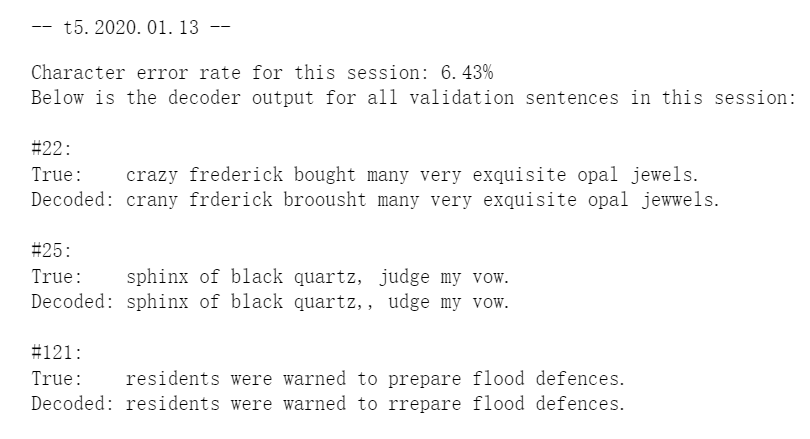

In [16]:
#Summarize character error rate and word error rate across all sessions.
#总结所有会话中的字符错误率和单词错误率。
concatErrCounts = np.squeeze(np.concatenate(allErrCounts, axis=0))
cer = 100*(np.sum(concatErrCounts[:,1]) / np.sum(concatErrCounts[:,0]))
wer = 100*(np.sum(concatErrCounts[:,3]) / np.sum(concatErrCounts[:,2]))

print('Character error rate: %1.2f%%' % float(cer))
print('Word error rate: %1.2f%%' % float(wer))

Character error rate: 2.78%
Word error rate: 12.88%
